In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# **Load Data**

In [ ]:
# Load datasets
train_df = pd.read_excel('train_product_data.xlsx')
test_df = pd.read_excel('test_data.xlsx')
test_results = pd.read_csv('test_results.csv')

# **Data Exploration**

In [ ]:
# Check basic information about datasets
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

In [ ]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  2534 non-null   object 
 1   crawl_timestamp          2534 non-null   object 
 2   product_url              2534 non-null   object 
 3   product_name             2534 non-null   object 
 4   pid                      2534 non-null   object 
 5   retail_price             2530 non-null   float64
 6   discounted_price         2530 non-null   float64
 7   image                    2534 non-null   object 
 8   is_FK_Advantage_product  2534 non-null   bool   
 9   description              2534 non-null   object 
 10  product_rating           2534 non-null   object 
 11  overall_rating           2534 non-null   object 
 12  brand                    2012 non-null   object 
 13  product_specifications   2529 non-null   object 
dtypes: bool(1), float64(2), 

In [ ]:
# Display first few rows of training data
print(train_df.head())

                            uniq_id            crawl_timestamp  \
0  c2d766ca982eca8304150849735ffef9  2016-03-25 22:59:23 +0000   
1  f449ec65dcbc041b6ae5e6a32717d01b  2016-03-25 22:59:23 +0000   
2  0973b37acd0c664e3de26e97e5571454  2016-03-25 22:59:23 +0000   
3  ce5a6818f7707e2cb61fdcdbba61f5ad  2016-03-25 22:59:23 +0000   
4  29c8d290caa451f97b1c32df64477a2c  2016-03-25 22:59:23 +0000   

                                         product_url  \
0  http://www.flipkart.com/alisha-solid-women-s-c...   
1  http://www.flipkart.com/aw-bellies/p/itmeh4grg...   
2  http://www.flipkart.com/alisha-solid-women-s-c...   
3  http://www.flipkart.com/alisha-solid-women-s-c...   
4  http://www.flipkart.com/dilli-bazaaar-bellies-...   

                                        product_name product_category_tree  \
0                Alisha Solid Women's Cycling Shorts              Clothing   
1                                         AW Bellies              Footwear   
2                Alisha Solid Wo

# **Data Preprocessing**

In [ ]:
# Handle missing values
train_df = train_df.dropna(subset=['product_category_tree', 'description'])

# **Visualize Data**

Here I have visualized the distribution of product categories in our dataset using a horizontal bar plot. This plot highlights the frequency of each category, showing which categories are most common and which are rare. Understanding this distribution helped me recognize potential class imbalances, guiding us in adjusting our model to ensure fair and accurate predictions across all categories.

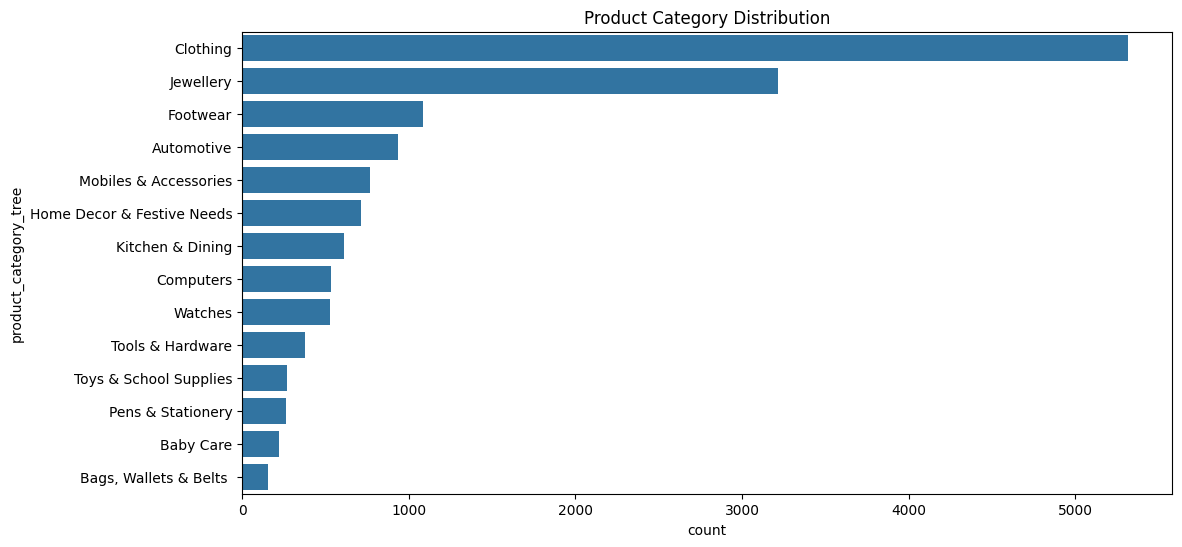

In [ ]:
# Plot category distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=train_df['product_category_tree'], order=train_df['product_category_tree'].value_counts().index)
plt.title('Product Category Distribution')
plt.show()


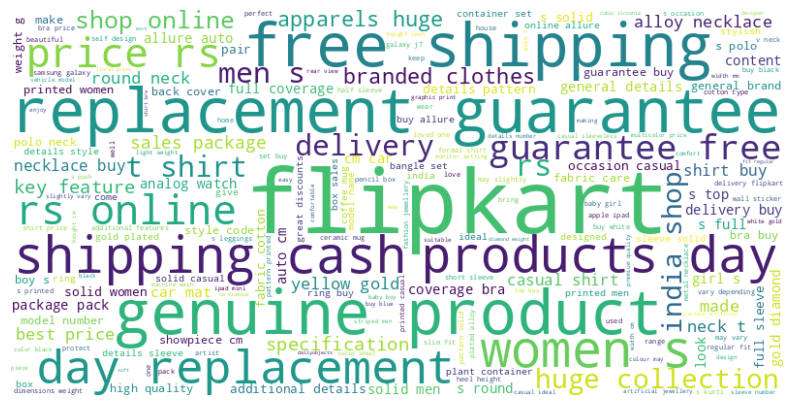

In [ ]:
# Generate word cloud for product descriptions
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_df['description']))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Feature Engineering**

**TF-IDF Vectorizer Initialization:**
vectorizer = TfidfVectorizer(max_features=5000): I have initialize a TF-IDF Vectorizer with a maximum of 5000 features. TF-IDF stands for Term Frequency-Inverse Document Frequency, a technique to transform text data into numerical representations by measuring the importance of words in a document relative to the entire dataset. Limiting to 5000 features helps balance between capturing essential information and maintaining computational efficiency.

**Transforming Training Data:**
X_train_tfidf = vectorizer.fit_transform(train_df['description']): I have fit the vectorizer on the description column of the training data and transform it. The fit_transform method learns the vocabulary from the training data and converts the descriptions into a sparse matrix of TF-IDF features. Each row in this matrix represents a product description, and each column corresponds to one of the 5000 features (words/terms).

**Transforming Test Data:**
X_test_tfidf = vectorizer.transform(test_df['description']): I have transform the descriptions in the test data using the same vocabulary learned from the training data. This ensures consistency in the feature space between training and test sets. The transform method converts the test descriptions into a sparse matrix of TF-IDF features without re-learning the vocabulary.

In [ ]:
# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df['description'])
X_test_tfidf = vectorizer.transform(test_df['description'])


**Label Encoder Initialization:**
from sklearn.preprocessing import LabelEncoder: I imported the LabelEncoder class from scikit-learn. This encoder is used to transform categorical labels into numerical format, which is required for most machine learning algorithms.

**Fitting and Transforming Labels:**
le = LabelEncoder(): I created an instance of the LabelEncoder.
y_train = le.fit_transform(train_df['product_category_tree']):Here I have fit the encoder on the product_category_tree column from the training data and transform it into numerical labels. Each unique category in the product_category_tree is assigned a unique integer. The fit_transform method accomplishes both the fitting and transforming in one step, resulting in an array of numerical labels corresponding to the product categories.

In [ ]:
# Convert target labels to numerical format
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df['product_category_tree'])

# **Address Class Imbalance**

**Handling Class Imbalance with SMOTE**

**SMOTE Initialization:**
smote = SMOTE(): I have initialized the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE is used to address class imbalance by generating synthetic examples for minority classes, thus balancing the dataset.

**Applying SMOTE:**
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train): I have applyed SMOTE to our training data. The fit_resample method oversamples the minority classes by creating synthetic samples, resulting in a balanced training set. This helps prevent the model from being biased towards the majority class.

In [ ]:
# Handle class imbalance using SMOTE
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# **Model Training**

**Training a Logistic Regression Model**

**Logistic Regression Initialization:**
model = LogisticRegression(max_iter=1000, class_weight='balanced'): I have initialized a Logistic Regression model with a maximum of 1000 iterations for convergence. The class_weight='balanced' parameter adjusts weights inversely proportional to class frequencies, further addressing any residual imbalance.

**Model Training:**
model.fit(X_train_balanced, y_train_balanced): I have trained the Logistic Regression model on the balanced training data. The fit method learns the relationship between the TF-IDF features and the corresponding category labels.

In [ ]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=1000)

# **Model Evaluation**

Training Accuracy: 0.9958661154820643
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       937
           1       0.90      1.00      0.95       224
           2       0.99      1.00      0.99       158
           3       1.00      0.99      1.00      5315
           4       0.99      0.99      0.99       531
           5       1.00      1.00      1.00      1083
           6       1.00      0.99      1.00       714
           7       1.00      1.00      1.00      3218
           8       1.00      1.00      1.00       610
           9       0.99      0.99      0.99       768
          10       0.98      0.96      0.97       264
          11       1.00      1.00      1.00       379
          12       0.96      0.98      0.97       271
          13       1.00      1.00      1.00       526

    accuracy                           1.00     14998
   macro avg       0.99      0.99      0.99     14998
weighted avg      

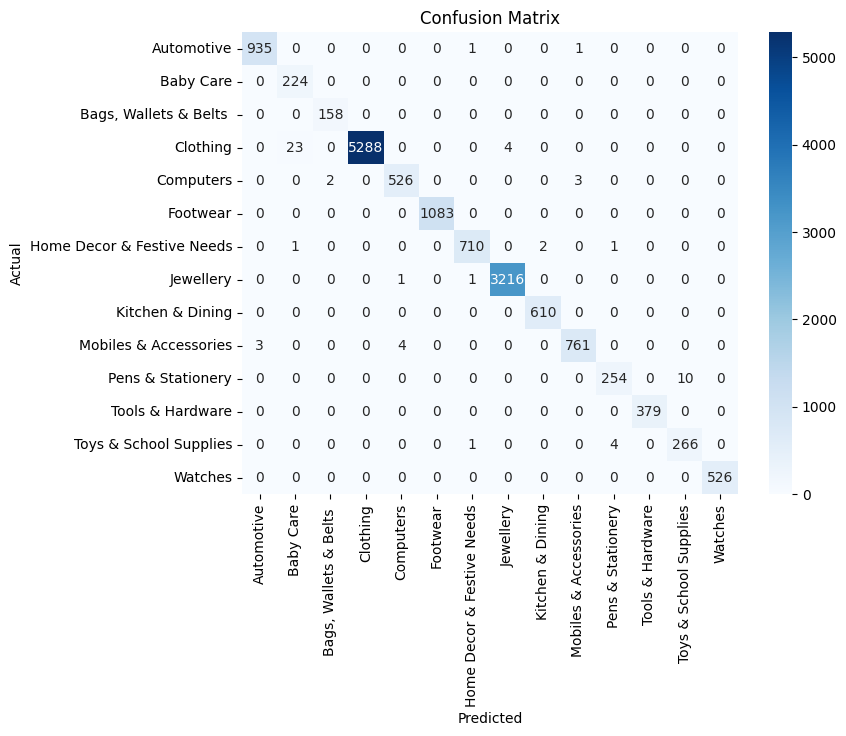

In [ ]:
# Predict on training data
y_train_pred = model.predict(X_train_tfidf)

# Evaluation metrics
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Classification Report:\n', classification_report(y_train, y_train_pred))

# Confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Predict on Test Data**

In [ ]:
# Predict categories for test data
test_predictions = model.predict(X_test_tfidf)
test_df['predicted_category'] = le.inverse_transform(test_predictions)


In [ ]:
# Save the results
test_df[['uniq_id', 'predicted_category']].to_csv('test_predictions.csv', index=False)

In [ ]:
result = pd.read_csv('test_predictions.csv')

In [ ]:
result.head(10)

,uniq_id,predicted_category
0,4fb99d98225f415e7ece96938e95628f,Jewellery
1,4ea284c8d38b2ea97a1c2a26f34e057c,Jewellery
2,ee6ce2c7045c54257e2a0b590e09c296,Mobiles & Accessories
3,e797ba3b5f2e2d1fdc520e48486ab60e,Jewellery
4,f4d8d43858c8858c68d75ce07ac641c0,Jewellery
5,9b82f9fda383649724d9a8c222201c75,Mobiles & Accessories
6,52f14c6349ca09801aca492933acf165,Jewellery
7,8c0a0477e6027d1638e3062da2756020,Mobiles & Accessories
8,231a26ee0bad0d8b9dc6c4f865454da7,Jewellery
9,33e8d05b2a6eb8625341b801b721f0c5,Mobiles & Accessories
